In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Spotify Popularity Prediction Problem

## What makes a song popular on Spotify?

The approach that we will follow will be the following:
- Load the data & clean it so that it is workable
- Exploratory Data Analysis where we search for interesting phenomena
- Build a model to predict popularity
- Check coefficients

### Loading the Data

In [9]:
df = pd.read_csv("dataset.csv")
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [10]:
df.shape

(114000, 21)

#### Drop `Unnamed: 0` column and potential dupes

In [11]:
df = df.drop('Unnamed: 0', axis=1)

data = df.drop_duplicates()
data.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [12]:
data.shape

(113550, 20)

## 1. Dataset and Properties

This project uses the Spotify Tracks Dataset, which contains comprehensive information about music tracks available on Spotify. The dataset consists of approximately 113,550 tracks and 20 feature columns after cleaning. This dataset was constructed such that each of the 114 unique genres has roughly 1000 tracks.

**Key features include:**
- **Track identifiers**: track_id, track_name, artists, album_name, track_genre
- **Popularity metric**: popularity (target variable, ranging 0-100)
- **Audio features**: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo
- **Technical attributes**: key, mode, time_signature, duration_ms, explicit

The dataset spans multiple music genres (acoustic, rock, pop, etc.) and contains tracks from various artists and time periods. The popularity score serves as the primary metric of interest, representing how well-received a track is on the platform.

### Categorical Cardinality

Computes a concise table showing unique counts, percentage unique, number of singletons, and top-5 values for important categorical columns (`track_genre`, `artists`, `album_name`, `track_name`). Shows small bar charts for the top categories.

,unique_count,pct_unique,singletons,top5
column,,,,
artists,31438,27.69%,16806,The Beatles (279); George Jones (260); Stevie Wonder (235); Linkin Park (224); Ella Fitzgerald (221)
album_name,46590,41.03%,28022,Alternative Christmas 2022 (195); Feliz Cumpleaños con Perreo (180); Metal (143); Halloween con perreito (122); Halloween Party 2022 (114)
track_name,73609,64.83%,55965,Run Rudolph Run (151); Halloween (88); Frosty The Snowman (80); Little Saint Nick - 1991 Remix (74); Christmas Time (72)


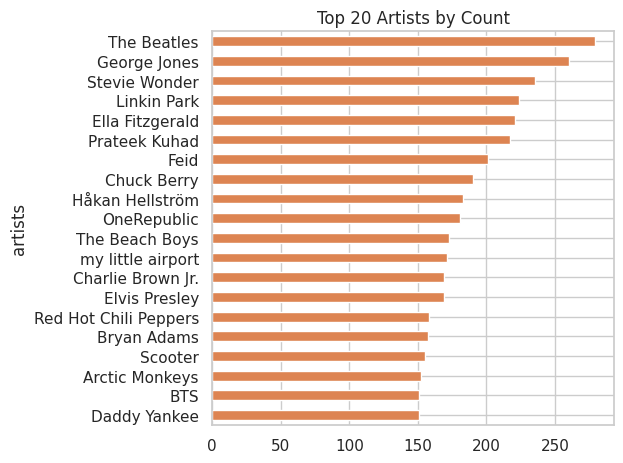

In [13]:
# Categorical cardinality summary
sns.set(style="whitegrid")

# columns to summarize
cat_cols = ['artists', 'album_name', 'track_name']

def summarize_cat(df, col):
    vc = df[col].value_counts(dropna=False)
    n = len(df)
    unique = vc.size
    singletons = (vc == 1).sum()
    top5 = vc.head(5)
    top5_str = '; '.join([f'{idx} ({cnt})' for idx, cnt in top5.items()])
    return {
        'column': col,
        'unique_count': unique,
        'pct_unique': unique / n if n>0 else 0,
        'singletons': int(singletons),
        'top5': top5_str
    }

# build the summary dataframe
cat_summaries = []
for c in cat_cols:
    if c in data.columns:
        cat_summaries.append(summarize_cat(data, c))
    else:
        cat_summaries.append({'column': c, 'unique_count': None, 'pct_unique': None, 'singletons': None, 'top5': 'MISSING'})

cat_cardinality_df = pd.DataFrame(cat_summaries).set_index('column')

# display the table inline
from IPython.display import display
display(cat_cardinality_df.style.format({'pct_unique': '{:.2%}'}))

# small multiples: top-20 for artists (if present)
fig, ax = plt.subplots()
if 'artists' in data.columns:
    avc = data['artists'].value_counts().nlargest(20).sort_values()
    avc.plot(kind='barh', ax=ax, color='C1')
    ax.set_title('Top 20 Artists by Count')
else:
    ax.text(0.5, 0.5, 'artists not found', ha='center')

plt.tight_layout()
plt.show()

**Interpretation:**

- `cat_cardinality_df` shows how many unique values each categorical column has and whether many values are singletons
- The bar charts show which artists dominate the dataset

### Genre & Artist Aggregation

Summary tables for `track_genre` and `artists`: count, mean/median/std popularity, mean audio features, and top representative tracks.

/tmp/ipykernel_255669/1277525017.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3 = genre_grp.apply(top_tracks_for_group).rename('top_3_tracks')


,count,mean_popularity,median_popularity,std_popularity,avg_danceability,avg_energy,avg_valence,avg_loudness,avg_tempo,avg_acousticness
artists,,,,,,,,,,
Olivia Rodrigo,5,87.40,88.00,0.89,0.468200,0.497800,0.285180,-7.736200,152.250200,0.628600
Bad Bunny,48,87.08,86.50,5.99,0.789583,0.646729,0.489604,-5.845583,115.858271,0.192419
Bad Bunny;Jhayco,8,87.00,87.00,4.28,0.763000,0.628500,0.282000,-7.015000,111.969500,0.211750
The Chainsmokers;Halsey,5,84.00,84.00,0.00,0.748000,0.524000,0.661000,-5.599000,95.010000,0.414000
Marshmello;Khalid,10,84.00,84.00,3.16,0.716000,0.767500,0.459000,-3.883000,130.968500,0.188500
Lil Nas X,7,83.71,83.00,4.64,0.687714,0.635857,0.583571,-5.747857,141.458857,0.157297
Måneskin,12,83.67,84.00,2.74,0.653833,0.725000,0.632833,-4.282667,127.820833,0.032928
One Direction,5,83.00,83.00,3.32,0.652800,0.688200,0.536800,-5.532600,116.278200,0.241266
TV Girl,5,82.00,82.00,1.22,0.616600,0.842200,0.572800,-6.011000,106.684200,0.291603


/tmp/ipykernel_255669/1277525017.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_popularity', y=top_genres.index, data=top_genres.reset_index(), ax=axes[0], palette='viridis')


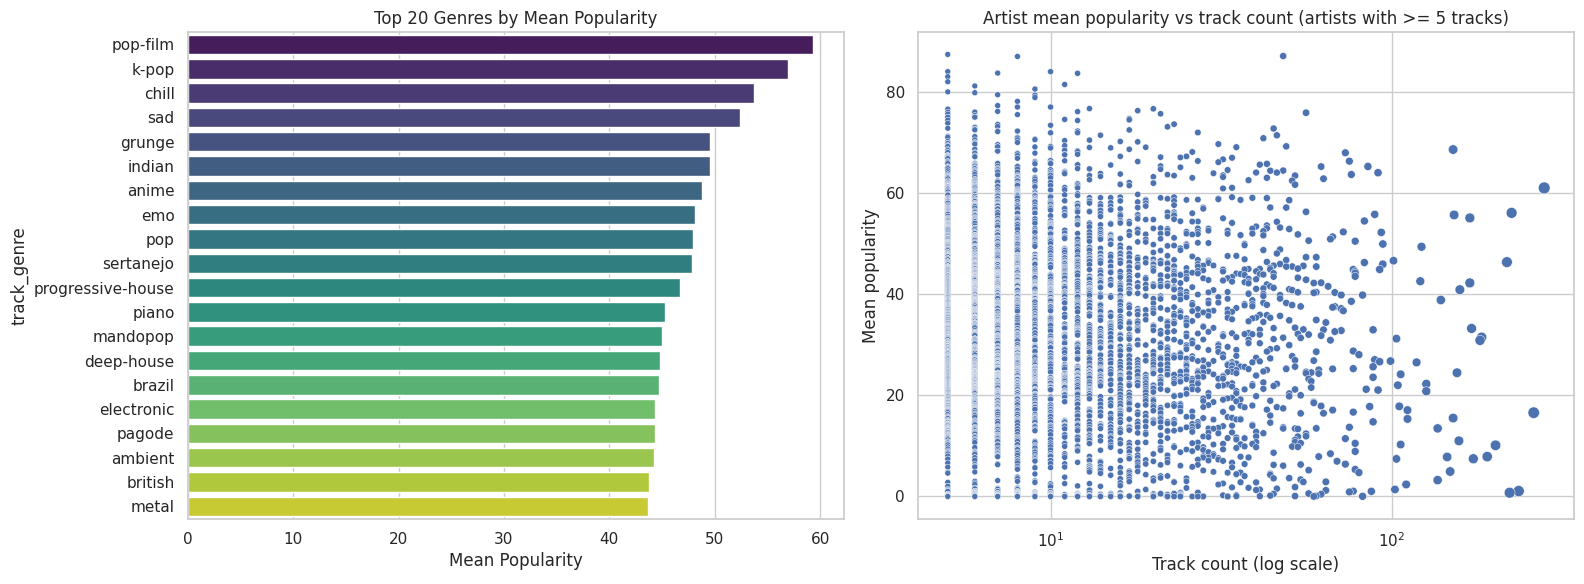

Top 20 artists by mean popularity (any count):


,count,mean_popularity
artists,,
Sam Smith;Kim Petras,2,100.0
Bizarrap;Quevedo,1,99.0
Manuel Turizo,4,98.0
Bad Bunny;Chencho Corleone,4,97.0
Bad Bunny;Bomba Estéreo,4,94.5
Joji,1,94.0
Beyoncé,1,93.0
Harry Styles,3,92.0
Rema;Selena Gomez,1,92.0


In [14]:
# Genre & Artist aggregation
sns.set(style="whitegrid")

# select audio features if present
audio_feats = ['danceability','energy','valence','loudness','tempo','acousticness']
present_audio_feats = [f for f in audio_feats if f in data.columns]

# ----- Genre aggregation -----
if 'track_genre' in data.columns:
    genre_grp = data.groupby('track_genre')
    genre_agg = genre_grp.agg(
        count=('popularity','size'),
        mean_popularity=('popularity','mean'),
        median_popularity=('popularity','median'),
        std_popularity=('popularity','std')
    )
    # add mean audio features if available
    for f in present_audio_feats:
        genre_agg[f'avg_{f}'] = genre_grp[f].mean()
    # top-3 tracks per genre (track_name may be missing)
    def top_tracks_for_group(g):
        if 'track_name' in g.columns and 'popularity' in g.columns:
            top = g.sort_values('popularity', ascending=False).head(3)
            return '; '.join([f"{row['track_name']} ({int(row['popularity'])})" for _, row in top.iterrows() if pd.notnull(row.get('track_name'))])
        return ''
    top3 = genre_grp.apply(top_tracks_for_group).rename('top_3_tracks')
    genre_agg_df = genre_agg.join(top3).sort_values('count', ascending=False)
    # display(genre_agg_df.head(30).style.format({k: '{:.2f}' for k in ['mean_popularity','median_popularity','std_popularity'] if k in genre_agg_df.columns}))
else:
    genre_agg_df = pd.DataFrame()
    print('No track_genre column found in data')

# ----- Artist aggregation -----
if 'artists' in data.columns:
    artist_grp = data.groupby('artists')
    artist_agg = artist_grp.agg(
        count=('popularity','size'),
        mean_popularity=('popularity','mean'),
        median_popularity=('popularity','median'),
        std_popularity=('popularity','std')
    )
    for f in present_audio_feats:
        artist_agg[f'avg_{f}'] = artist_grp[f].mean()
    # artists with at least k tracks to reduce noise
    k = 5
    artist_agg_filtered = artist_agg[artist_agg['count'] >= k].sort_values('mean_popularity', ascending=False)
    top20_overall = artist_agg.sort_values('mean_popularity', ascending=False).head(20)
    display(artist_agg_filtered.head(30).style.format({k: '{:.2f}' for k in ['mean_popularity','median_popularity','std_popularity'] if k in artist_agg_filtered.columns}))
else:
    artist_agg = pd.DataFrame()
    artist_agg_filtered = pd.DataFrame()
    top20_overall = pd.DataFrame()
    print('No artists column found in data')

# ----- Visualizations -----
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Mean popularity by genre (top 20 by count)
if not genre_agg_df.empty:
    top_genres = genre_agg_df.sort_values('mean_popularity', ascending=False).head(20)
    sns.barplot(x='mean_popularity', y=top_genres.index, data=top_genres.reset_index(), ax=axes[0], palette='viridis')
    axes[0].set_title('Top 20 Genres by Mean Popularity')
    axes[0].set_xlabel('Mean Popularity')
else:
    axes[0].text(0.5,0.5,'No genre data', ha='center')

# Artist mean popularity vs track count (filtered)
if not artist_agg_filtered.empty:
    art = artist_agg_filtered.reset_index()
    sns.scatterplot(x='count', y='mean_popularity', size='count', data=art, ax=axes[1], legend=False)
    axes[1].set_xscale('log')
    axes[1].set_title(f'Artist mean popularity vs track count (artists with >= {k} tracks)')
    axes[1].set_xlabel('Track count (log scale)')
    axes[1].set_ylabel('Mean popularity')
else:
    axes[1].text(0.5,0.5,'No artist data (with >= k tracks)', ha='center')

plt.tight_layout()
plt.show()

# show top 20 artists overall by mean popularity for quick inspection
if not top20_overall.empty:
    print('Top 20 artists by mean popularity (any count):')
    display(top20_overall[['count','mean_popularity']])

**Interpretation:**

- `genre_agg_df` quantifies per-genre popularity and average audio features.
- `artist_agg` indicates which artists have consistently high average popularity; the scatterplot shows whether popularity is concentrated among prolific artists.

### Univariate Analysis (numeric features)

Compute numeric summaries (count, missing%, mean, median, std, min/max, skewness, kurtosis) and render histograms + KDEs and boxplots. Also show popularity bucket counts.

,density
popularity,
0-20,0.297930
21-40,0.291317
41-60,0.291325
61-80,0.111035
81-100,0.008393


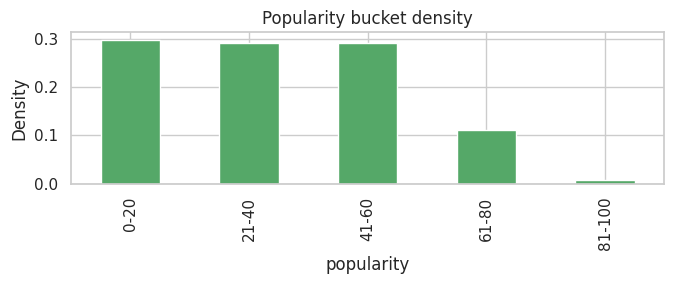

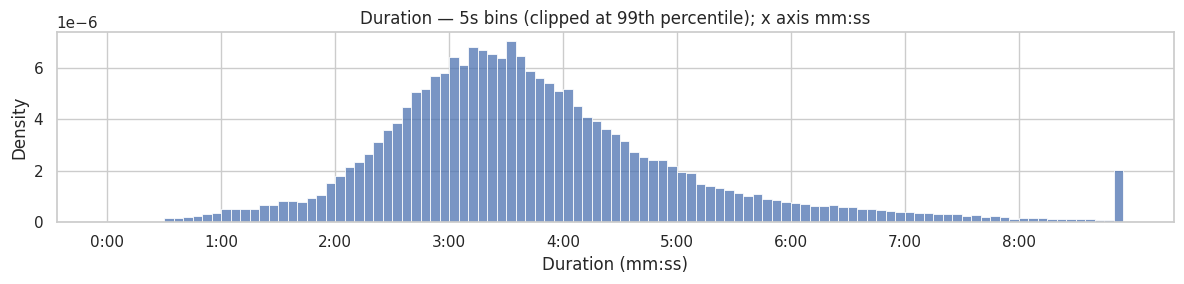

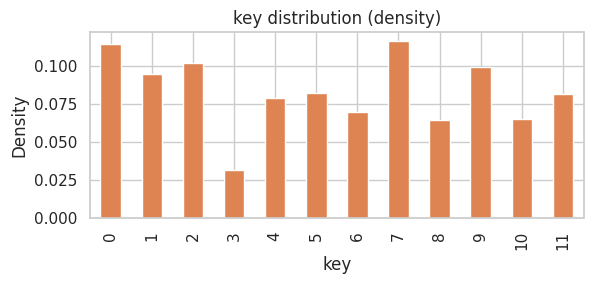

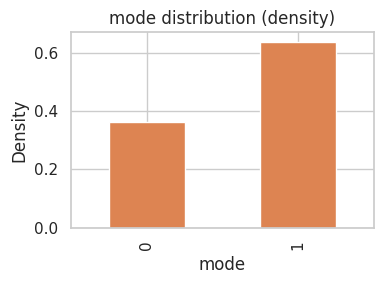

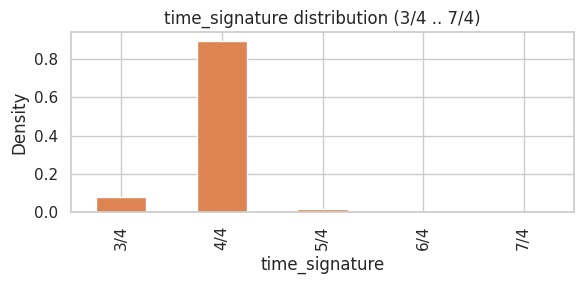

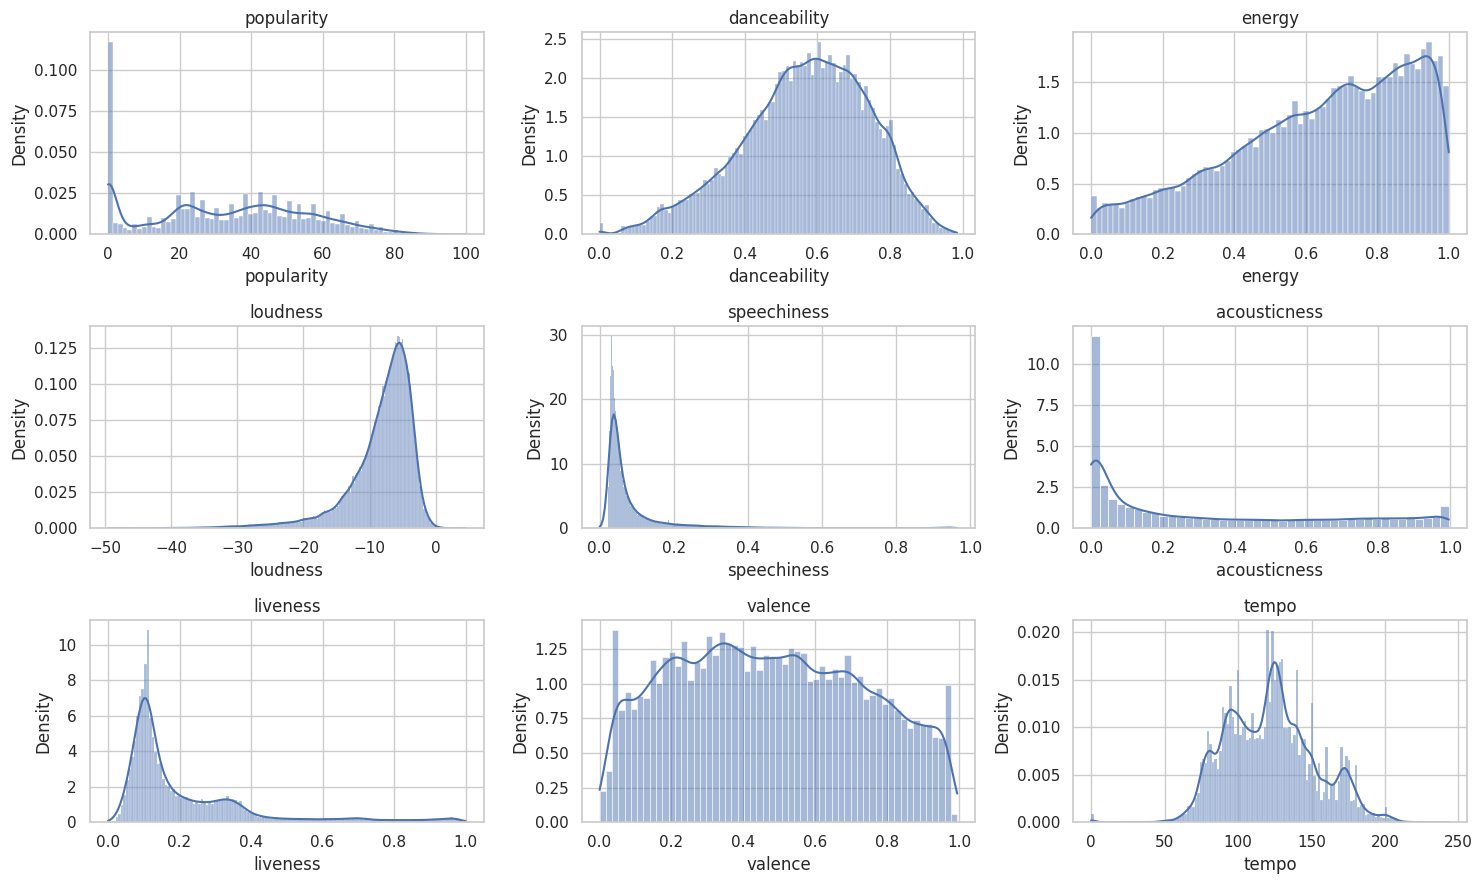

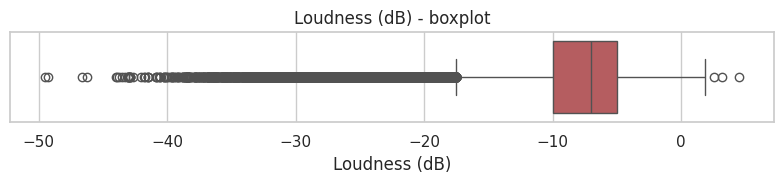

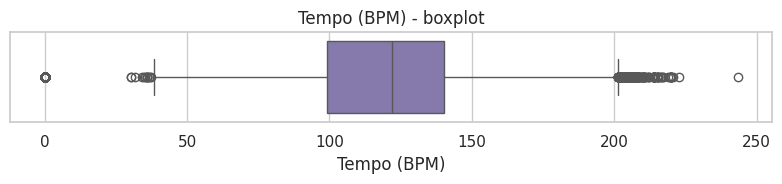

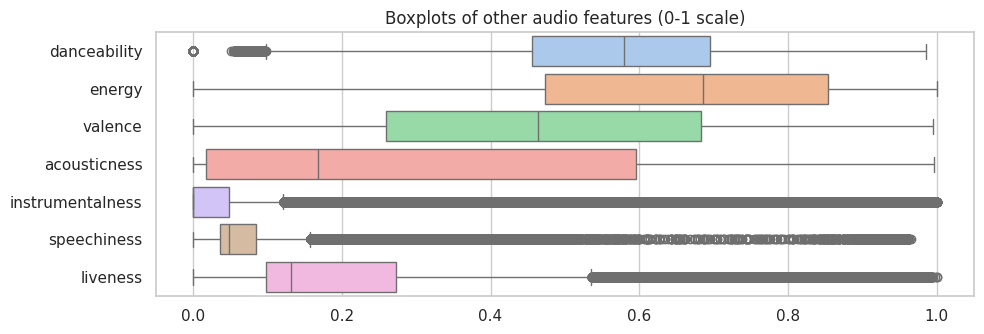

Features with |skew| > 1 (consider transform or winsorize): ['duration_ms', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'time_signature']


In [15]:
# Univariate numeric summary and plots (inline)
sns.set(style="whitegrid")

# select numeric columns (exclude booleans treated as numeric if desired)
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
# optional: drop index-like or id columns if present
drop_if_present = ['Unnamed: 0']
numeric_cols = [c for c in numeric_cols if c not in drop_if_present]

# build summary dataframe
df_num = data[numeric_cols].copy()
desc = df_num.describe().T
desc['missing_pct'] = df_num.isna().mean()
desc['skew'] = df_num.skew()
desc['kurtosis'] = df_num.kurtosis()
# reorder columns for readability
numeric_summary_df = desc[['missing_pct','count','mean','std','min','25%','50%','75%','max','skew','kurtosis']]
# display summary nicely
# display(numeric_summary_df.style.format({'missing_pct': '{:.2%}', 'mean': '{:.3f}', 'std': '{:.3f}', 'skew': '{:.3f}', 'kurtosis': '{:.3f}'}))

# Popularity buckets (if popularity present) - show density (normalize)
if 'popularity' in data.columns:
    bins = [0,20,40,60,80,100]
    labels = ['0-20','21-40','41-60','61-80','81-100']
    pop_bucket = pd.cut(data['popularity'], bins=bins, labels=labels, include_lowest=True)
    pop_counts = pop_bucket.value_counts(normalize=True).reindex(labels)
    display(pop_counts.to_frame(name='density'))
    fig, ax = plt.subplots(figsize=(7,3))
    pop_counts.plot(kind='bar', ax=ax, color='C2')
    ax.set_title('Popularity bucket density')
    ax.set_ylabel('Density')
    plt.tight_layout()
    plt.show()
else:
    print('No popularity column found for bucket plot')

# Special handling for certain columns as requested
# Duration: bin into 5-second intervals and clip outliers at 99th percentile; display x as mm:ss
if 'duration_ms' in data.columns:
    dur = data['duration_ms'].dropna()
    clip = dur.quantile(0.99)
    bins = np.arange(0, clip + 5000, 5000)  # 5000 ms = 5 seconds
    fig, ax = plt.subplots(figsize=(12,3))
    sns.histplot(dur.clip(upper=clip), bins=bins, kde=False, stat='density', ax=ax, color='C0')
    # set xticks every 60s (60000 ms) and format as mm:ss
    def ms_to_mmss(ms):
        m = int(ms) // 60000
        s = (int(ms) % 60000) // 1000
        return f"{m}:{s:02d}"
    xt = np.arange(0, clip + 1, 60000)
    xt = xt[xt <= clip]
    ax.set_xticks(xt)
    ax.set_xticklabels([ms_to_mmss(x) for x in xt])
    ax.set_title('Duration — 5s bins (clipped at 99th percentile); x axis mm:ss')
    ax.set_xlabel('Duration (mm:ss)')
    ax.set_ylabel('Density')
    plt.tight_layout()
    plt.show()

# Categorical-numeric columns: key, mode, time_signature — show bar charts of density
# key and mode default: normalized bar charts
if 'key' in data.columns:
    vc = data['key'].value_counts(normalize=True).sort_index()
    fig, ax = plt.subplots(figsize=(6,3))
    vc.plot(kind='bar', ax=ax, color='C1')
    ax.set_ylabel('Density')
    ax.set_title('key distribution (density)')
    plt.tight_layout()
    plt.show()

if 'mode' in data.columns:
    vc = data['mode'].value_counts(normalize=True).sort_index()
    fig, ax = plt.subplots(figsize=(4,3))
    vc.plot(kind='bar', ax=ax, color='C1')
    ax.set_ylabel('Density')
    ax.set_title('mode distribution (density)')
    plt.tight_layout()
    plt.show()

# time_signature: show range 3..7 and label x as fractions x/4
if 'time_signature' in data.columns:
    vals = list(range(3,8))
    vc = data['time_signature'].value_counts(normalize=True).reindex(vals, fill_value=0)
    fig, ax = plt.subplots(figsize=(6,3))
    vc.plot(kind='bar', ax=ax, color='C1')
    ax.set_ylabel('Density')
    ax.set_title('time_signature distribution (3/4 .. 7/4)')
    ax.set_xticklabels([f'{v}/4' for v in vals])
    ax.set_xlim(-0.5, len(vals)-0.5)
    plt.tight_layout()
    plt.show()

# Histograms + KDEs for remaining numeric columns (exclude the special columns above)
exclude = {'duration_ms','key','mode','time_signature','instrumentalness'}
other_numeric = [c for c in numeric_cols if c not in exclude]
n = len(other_numeric)
if n>0:
    cols = 3
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
    axes = axes.flatten()
    for i, col in enumerate(other_numeric):
        ax = axes[i]
        sns.histplot(data[col].dropna(), kde=True, ax=ax, color='C0', stat='density')
        ax.set_title(col)
    # hide leftover axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

# Boxplots: separate loudness, tempo, and other audio features
all_audio_feats = ['danceability','energy','valence','loudness','tempo','acousticness','instrumentalness','speechiness','liveness']
audio_feats_present = [f for f in all_audio_feats if f in data.columns]

if 'loudness' in data.columns:
    fig, ax = plt.subplots(figsize=(8, 2))
    sns.boxplot(x=data['loudness'].dropna(), ax=ax, color='C3')
    ax.set_title('Loudness (dB) - boxplot')
    ax.set_xlabel('Loudness (dB)')
    plt.tight_layout()
    plt.show()

if 'tempo' in data.columns:
    fig, ax = plt.subplots(figsize=(8, 2))
    sns.boxplot(x=data['tempo'].dropna(), ax=ax, color='C4')
    ax.set_title('Tempo (BPM) - boxplot')
    ax.set_xlabel('Tempo (BPM)')
    plt.tight_layout()
    plt.show()

# Other audio features (exclude loudness and tempo)
other_feats = [f for f in audio_feats_present if f not in ['loudness', 'tempo']]
if len(other_feats) > 0:
    fig, ax = plt.subplots(figsize=(10, max(3, 0.5*len(other_feats))))
    sns.boxplot(data=data[other_feats], orient='h', ax=ax, palette='pastel')
    ax.set_title('Boxplots of other audio features (0-1 scale)')
    plt.tight_layout()
    plt.show()

# Suggest transforms for highly skewed features
skewed = numeric_summary_df[numeric_summary_df['skew'].abs() > 1].index.tolist()
print('Features with |skew| > 1 (consider transform or winsorize):', skewed)

**Interpretation:**

- Features listed with |skew| > 1 are candidates for log/winsorization or transformation before modeling.
- Histograms/KDEs reveal distributional shapes; use median or robust scalers for heavy-tailed features. The audio-feature boxplots highlight outliers — consider winsorizing extreme values or capping by percentiles.

### Category-level Analyses

Violin/boxplots of popularity for top-N genres and small multiples of key audio features by genre. Compact top-tracks (top-10) list per genre.

/tmp/ipykernel_255669/3326072353.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='track_genre', y='popularity', data=df_g, order=order, palette='Set3', cut=0, inner='quartile', ax=ax)


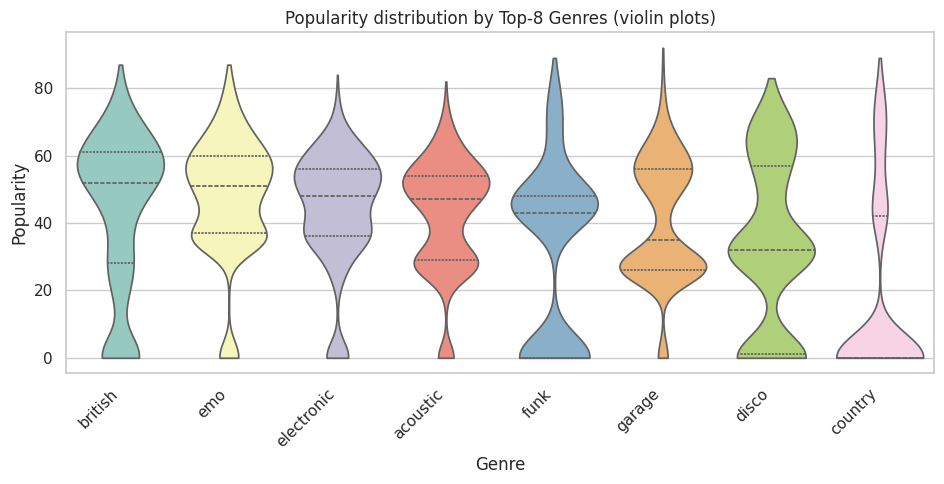

/tmp/ipykernel_255669/3326072353.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='track_genre', y=feat, data=df_g, order=order, ax=ax, palette='pastel')
/tmp/ipykernel_255669/3326072353.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='track_genre', y=feat, data=df_g, order=order, ax=ax, palette='pastel')
/tmp/ipykernel_255669/3326072353.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='track_genre', y=feat, data=df_g, order=order, ax=ax, palette='pastel')
/tmp/ipykernel_255669/3326072353.py:45: FutureWarning: 

Passing `p

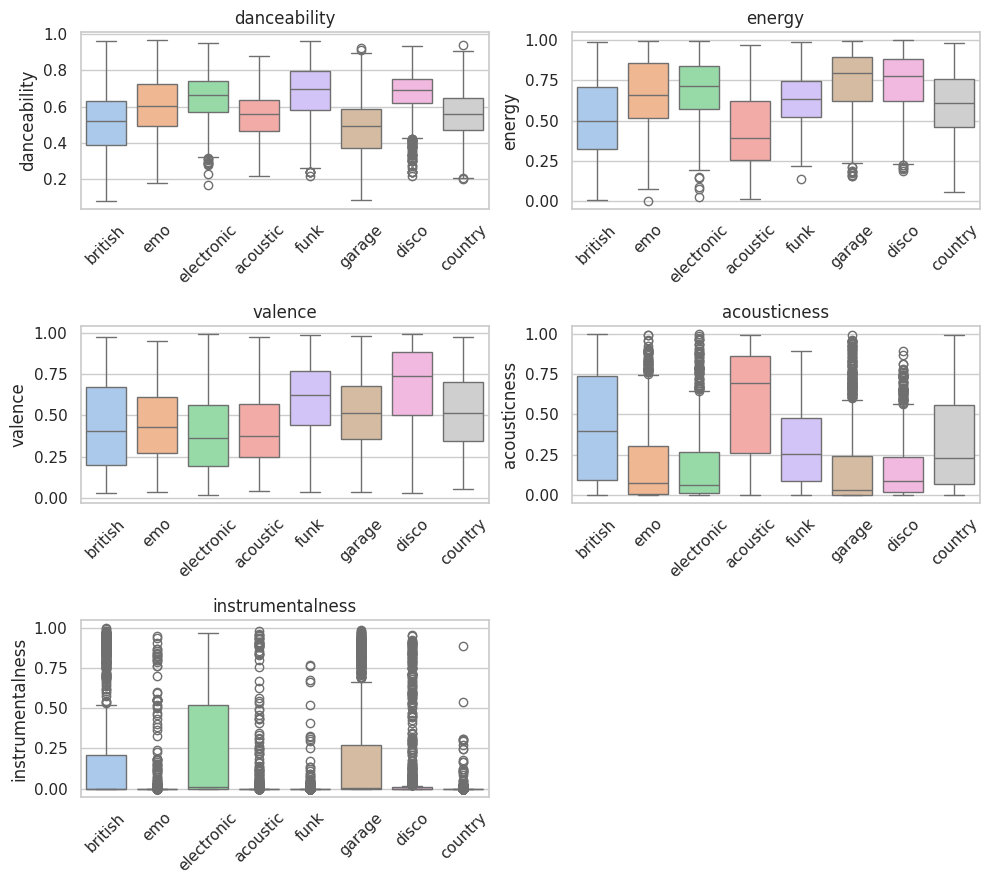

/tmp/ipykernel_255669/3326072353.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_k = df_g.groupby('track_genre').apply(lambda g: top_tracks(g, k=10)).rename('top_10_tracks')


,top_10_tracks
track_genre,
acoustic,Hold On (82); I'm Yours (80); Pano (75); I'm Y...
british,Only Love Can Hurt Like This (87); Easy On Me ...
country,Something in the Orange (89); You Proof (86); ...
disco,September (83); Wake Me Up Before You Go-Go (8...
electronic,Let Me Love You (84); Shootout (78); SG (with ...
emo,Revenge (87); Hope (86); Everybody Dies In The...
funk,Gangsta's Paradise (89); Still D.R.E. (84); En...
garage,I Wanna Be Yours (92); Why'd You Only Call Me ...


In [16]:
# Category-level analyses: violin plots and top-tracks per genre
sns.set(style="whitegrid")

# Number of top genres to inspect
N = 8

if 'track_genre' in data.columns:
    # determine top-N genres by count (prefer genre_agg_df if available)
    try:
        use_df = genre_agg_df if 'genre_agg_df' in globals() and not genre_agg_df.empty else None
    except Exception:
        use_df = None
    if use_df is not None:
        top_genres = use_df['count'].nlargest(N).index.tolist()
    else:
        top_genres = data['track_genre'].value_counts().nlargest(N).index.tolist()

    df_g = data[data['track_genre'].isin(top_genres)].copy()
    # order genres by median popularity (descending)
    order = df_g.groupby('track_genre')['popularity'].median().sort_values(ascending=False).index.tolist()

    # Violin plot: popularity distribution by genre
    fig, ax = plt.subplots(figsize=(max(8, len(order)*1.2), 5))
    sns.violinplot(x='track_genre', y='popularity', data=df_g, order=order, palette='Set3', cut=0, inner='quartile', ax=ax)
    ax.set_title(f'Popularity distribution by Top-{N} Genres (violin plots)')
    ax.set_xlabel('Genre')
    ax.set_ylabel('Popularity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Small multiples: selected audio features by genre (boxplots)
    sel_feats = [f for f in ['danceability','energy','valence','acousticness','instrumentalness'] if f in data.columns]
    if len(sel_feats) > 0:
        cols = 2
        rows = int(__import__('math').ceil(len(sel_feats)/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
        axes = axes.flatten()
        for i, feat in enumerate(sel_feats):
            ax = axes[i]
            sns.boxplot(x='track_genre', y=feat, data=df_g, order=order, ax=ax, palette='pastel')
            ax.set_title(feat)
            ax.set_xlabel('')
            ax.tick_params(axis='x', rotation=45)
        # remove any unused axes
        for j in range(i+1, len(axes)):
            try:
                fig.delaxes(axes[j])
            except Exception:
                pass
        plt.tight_layout()
        plt.show()

    # Top-10 tracks per genre (compact table)
    def top_tracks(g, k=10):
        if 'track_name' in g.columns and 'popularity' in g.columns:
            top = g.sort_values('popularity', ascending=False).head(k)
            # join track names with their integer popularity in parentheses
            return '; '.join([f"{r['track_name']} ({int(r['popularity'])})" for _, r in top.iterrows() if pd.notnull(r.get('track_name'))])
        return ''

    top_k = df_g.groupby('track_genre').apply(lambda g: top_tracks(g, k=10)).rename('top_10_tracks')
    display(top_k.to_frame())
else:
    print('No track_genre column found — cannot compute category-level analyses')

**Interpretation:**

- Violin plots show the full popularity distribution per genre (including multimodality); order by median helps spot consistently popular genres.
- The audio-feature small multiples (boxplots) reveal whether genres differ systematically on danceability, energy, valence, etc.
- The `top_10_tracks` list per genre gives representative examples for qualitative inspection.

## 2. Predictive Task and Relevant Features

**Task Definition:** Predict the popularity score (0-100) of a Spotify track based on its audio features and metadata.

This is a **regression task** where the target variable is the continuous popularity score. The goal is to understand which musical characteristics and attributes contribute to a track's success on the platform.

**Relevant Features:**

1. **Audio Features** (expected to be highly predictive):
   - `danceability`: Rhythmic suitability for dancing
   - `energy`: Intensity and activity measure
   - `valence`: Musical positiveness/happiness
   - `tempo`: Beats per minute
   - `loudness`: Overall volume in decibels

2. **Compositional Features**:
   - `acousticness`: Likelihood of being acoustic
   - `instrumentalness`: Predicts absence of vocals
   - `speechiness`: Presence of spoken words
   - `liveness`: Presence of audience in recording

3. **Metadata**:
   - `track_genre`: Genre classification
   - `explicit`: Explicit content flag
   - `duration_ms`: Track length

These features are expected to influence popularity because they capture the musical qualities that listeners respond to, as well as structural characteristics that affect discoverability and engagement.

## 3. Models

**Baselines:** Mean baseline, Genre-based baseline, Artist-based baseline

**Main Models:** Linear Regression, Ridge Regression, Random Forest

### Mean Baseline

In [17]:
# Avg. popularity for all tracks
pop_mean = data['popularity'].mean()
mean_baseline = data.copy()
mean_baseline['pop_prediction'] = pop_mean

# MSE
mse = mean_squared_error(mean_baseline['popularity'], 
                         mean_baseline['pop_prediction'])
print(mse)

# MAE
mae = mean_absolute_error(mean_baseline['popularity'],
                          mean_baseline['pop_prediction'])
print(mae)

496.5712173897094
18.856063374064775


### Genre-based Baseline

In [18]:
# mean popularity for each genre
genre_means = data.groupby('track_genre')['popularity'].mean()

# map each song to its genre mean
genre_baseline = data.copy()
genre_baseline['pop_prediction'] = genre_baseline['track_genre'].map(genre_means)

# MSE
mse = mean_squared_error(genre_baseline['popularity'], 
                         genre_baseline['pop_prediction'])
print(mse)

# MAE
mae = mean_absolute_error(genre_baseline['popularity'],
                          genre_baseline['pop_prediction'])
print(mae)

371.43731658373054
14.148002763983355


### Artist-based Baseline

For each artist, calculate mean of popularity of all songs that has them as co-artist, let's call it $p_{am}$. Then, for each song, set the popularity as the mean of all its artists' $p_{am}$.

In [128]:
# Split train valid so that valid doesn't leak info
train_data, valid_data = train_test_split(data, test_size=0.2, random_state=42)
global_mean = train_data['popularity'].mean()

# Turn to list of artists
train_data['artists'] = train_data['artists'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
valid_data['artists'] = valid_data['artists'].apply(lambda x: x.split(';') if isinstance(x, str) else [])

train_exploded = train_data.explode('artists')

# Calculate artist means from training data only
artist_means_train = train_exploded.groupby('artists')['popularity'].mean().to_dict()

# Set mean predictions of all songs based on artist means in training data
train_data['artist_mean'] = train_data['artists'].apply(lambda lst: global_mean if not lst else np.nanmean([artist_means_train.get(a, global_mean) for a in lst]))
valid_data['artist_mean'] = valid_data['artists'].apply(lambda lst: global_mean if not lst else np.nanmean([artist_means_train.get(a, global_mean) for a in lst]))

print("Train MSE:", mean_squared_error(train_data['popularity'], train_data['artist_mean']))
print("Train MAE:", mean_absolute_error(train_data['popularity'], train_data['artist_mean']))

print("Valid MSE:", mean_squared_error(valid_data['popularity'], valid_data['artist_mean']))
print("Valid MAE:", mean_absolute_error(valid_data['popularity'], valid_data['artist_mean']))


Train MSE: 167.38496680093922
Train MAE: 7.606591641223824
Valid MSE: 230.69854682183347
Valid MAE: 9.645067875824871


### Preparing train and valid set

Preparing dataset with the following features (most of these are scores):
- artists_mean: Average of mean of popularity of all artists associated with the song (known in the training set). If artist doesn't exist before use fallback (global mean)
- is_known_artist: Denote whether this song's artists are known (mostly for masking, will be explained below)
- duration_ms
- acousticness
- danceability
- energy
- instrumentalness
- liveness
- loudness
- speechiness
- tempo
- valence
- track_genre (One-hot)
- explicit (Y/N)

Idea: Since predicting based on the artist mean only is good for artist previously seen, we want to train the model for cold-start cases, where an artist is never seen before. The main idea is to dropout/mask some songs to hide their mean artist score by replacing it with the global mean and set the is_known_artist flag off.

In [121]:
# Model with ALL features including categorical variables
# Using Random Forest (naturally handles categorical data) and encoded Linear Regression

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Define all feature columns
numeric_features = [
    'duration_ms', 'acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'loudness',
    'speechiness', 'tempo', 'valence'
]
categorical_features = ['track_genre', 'explicit']

# Prepare data - handle categorical features
data_model = data.copy()

# Convert boolean to int
if 'explicit' in data_model.columns:
    data_model['explicit'] = data_model['explicit'].astype(int)

# Encode track_genre using one-hot encoding for linear models
if 'track_genre' in data_model.columns:
    genre_dummies = pd.get_dummies(data_model['track_genre'], prefix='genre')
    data_model = pd.concat([data_model, genre_dummies], axis=1)

# Get all feature columns for the model
genre_cols = [col for col in data_model.columns if col.startswith('genre_')]
all_features = numeric_features + ['explicit'] + genre_cols

all_features += ['artists']

# Split data
X_all = data_model[all_features].copy()
y_all = data_model['popularity']

X_all['artists'] = X_all['artists'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
X_all['is_known_artist'] = True

X_train_all, X_valid_all, y_train_all, y_valid_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=67
)
global_mean = y_train_all.mean()

# Get popularity means in training data for each artist
train_tmp = X_train_all.copy()
train_tmp['popularity'] = y_train_all

train_exploded = train_tmp.explode('artists')

# Dict mapping from artists to their mean (training set)
artist_means_train = train_exploded.groupby('artists')['popularity'].mean().to_dict()

X_train_all['artist_mean'] = X_train_all['artists'].apply(lambda lst: global_mean if not lst else np.nanmean([artist_means_train.get(a, global_mean) for a in lst]))
X_valid_all['artist_mean'] = X_valid_all['artists'].apply(lambda lst: global_mean if not lst else np.nanmean([artist_means_train.get(a, global_mean) for a in lst]))

# Dropout some artist_mean to represent unknown new artists
dropout_rate = 0.4
np.random.seed(67)
mask = np.random.rand(len(X_train_all)) < dropout_rate
X_train_all.loc[mask, 'artist_mean'] = global_mean # Replace with global_mean (of training set)
X_train_all.loc[mask, 'is_known_artist'] = False
print(f"Masked {sum(mask)} artists in training to simulate cold-start scenarios.")

# Finishing up the artist_mean prep
X_train_all.drop(columns=['artists'], inplace=True)
X_valid_all.drop(columns=['artists'], inplace=True)

X_valid_new_all = X_valid_all.copy()
X_valid_new_all['artist_mean'] = global_mean
X_valid_new_all['is_known_artist'] = False

print(f"Total features: {len(all_features)}")
print(f"Numeric: {len(numeric_features)}, Explicit: 1, Genre dummies: {len(genre_cols)}, Artist info: 1")

Masked 36331 artists in training to simulate cold-start scenarios.
Total features: 126
Numeric: 10, Explicit: 1, Genre dummies: 114, Artist info: 1


In [129]:
print(X_train_all.head())

       duration_ms  acousticness  danceability  energy  instrumentalness  \
13445       340665       0.01260         0.788   0.841          0.509000   
41327       162626       0.00949         0.334   0.830          0.004020   
8741        302002       0.01290         0.783   0.554          0.000000   
76600       183666       0.94400         0.174   0.327          0.000249   
98404       140333       0.24700         0.686   0.467          0.000000   

       liveness  loudness  speechiness    tempo  valence  ...  genre_swedish  \
13445    0.0537    -7.559       0.0697  124.008    0.618  ...          False   
41327    0.1060    -9.359       0.0654  178.187    0.633  ...          False   
8741     0.0956    -4.854       0.1520   95.001    0.541  ...          False   
76600    0.6550   -14.295       0.0613   85.517    0.272  ...          False   
98404    0.1720   -10.218       0.0420  121.075    0.441  ...          False   

       genre_synth-pop  genre_tango  genre_techno  genre_tranc

### Linear Regression

In [123]:
# Linear Regression with all features
print("="*60)
print("LINEAR REGRESSION WITH ALL FEATURES")
print("="*60)

lr_all = sklearn.linear_model.LinearRegression()
lr_all.fit(X_train_all, y_train_all)

train_preds_lr = lr_all.predict(X_train_all)
valid_new_preds_lr = lr_all.predict(X_valid_new_all)
valid_preds_lr = lr_all.predict(X_valid_all)

print("\nLinear Regression Results:")
print(f"Train MSE: {mean_squared_error(y_train_all, train_preds_lr):.2f}")
print(f"Train MAE: {mean_absolute_error(y_train_all, train_preds_lr):.2f}")

print(f"Valid MSE with known artist: {mean_squared_error(y_valid_all, valid_preds_lr):.2f}")
print(f"Valid MAE with known artist: {mean_absolute_error(y_valid_all, valid_preds_lr):.2f}")

print(f"Valid MSE masked artist: {mean_squared_error(y_valid_all, valid_new_preds_lr):.2f}")
print(f"Valid MAE masked artist: {mean_absolute_error(y_valid_all, valid_new_preds_lr):.2f}")

LINEAR REGRESSION WITH ALL FEATURES

Linear Regression Results:
Train MSE: 272.23
Train MAE: 11.77
Valid MSE with known artist: 229.32
Valid MAE with known artist: 10.21
Valid MSE masked artist: 401.76
Valid MAE masked artist: 16.04


### Random Forest

In [127]:
# Random Forest Regressor
print("="*60)
print("RANDOM FOREST REGRESSOR")
print("="*60)

# Train Random Forest with default parameters
rf = sklearn.ensemble.RandomForestRegressor(random_state=0, n_jobs=-1)
print(X_train_all.shape, y_train_all.shape)
rf.fit(X_train_all, y_train_all)

train_preds_rf = rf.predict(X_train_all)
valid_new_preds_rf = rf.predict(X_valid_new_all)
valid_preds_rf = rf.predict(X_valid_all)

print("\nRandom Forest Results:")
print(f"Train MSE: {mean_squared_error(y_train_all, train_preds_rf):.2f}")
print(f"Train MAE: {mean_absolute_error(y_train_all, train_preds_rf):.2f}")

print(f"Valid MSE with known artist: {mean_squared_error(y_valid_all, valid_preds_rf):.2f}")
print(f"Valid MAE with known artist: {mean_absolute_error(y_valid_all, valid_preds_rf):.2f}")

print(f"Valid MSE masked artist: {mean_squared_error(y_valid_all, valid_new_preds_rf):.2f}")
print(f"Valid MAE masked artist: {mean_absolute_error(y_valid_all, valid_new_preds_rf):.2f}")

print(f"Feature importances (top 10):")
importances = pd.Series(rf.feature_importances_, index=X_train_all.columns)
print(importances.sort_values(ascending=False).head(10))

RANDOM FOREST REGRESSOR
(90840, 127) (90840,)

Random Forest Results:
Train MSE: 36.63
Train MAE: 3.44
Valid MSE with known artist: 193.29
Valid MAE with known artist: 8.15
Valid MSE masked artist: 288.82
Valid MAE masked artist: 11.97
Feature importances (top 10):
artist_mean     0.415930
loudness        0.041365
tempo           0.041190
acousticness    0.041056
danceability    0.040926
speechiness     0.040442
duration_ms     0.040080
valence         0.040061
energy          0.037905
liveness        0.037412
dtype: float64


### k-NN models

In [40]:
# k-Nearest Neighbor
print("="*60)
print("K-NEAREST NEIGHBOR")
print("="*60)

# Train KNN with default parameters
knn = sklearn.neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=50)
print(X_train_all.shape, y_train_all.shape)
knn.fit(X_train_all, y_train_all)

train_preds_knn = knn.predict(X_train_all)
valid_preds_knn = knn.predict(X_valid_all)

print("\nK-Nearest Neighbor Results:")
print(f"Train MSE: {mean_squared_error(y_train_all, train_preds_knn):.2f}")
print(f"Valid MSE: {mean_squared_error(y_valid_all, valid_preds_knn):.2f}")
print(f"Train MAE: {mean_absolute_error(y_train_all, train_preds_knn):.2f}")
print(f"Valid MAE: {mean_absolute_error(y_valid_all, valid_preds_knn):.2f}")

K-NEAREST NEIGHBOR
(90840, 125) (90840,)

K-Nearest Neighbor Results:
Train MSE: 453.84
Valid MSE: 477.33
Train MAE: 17.75
Valid MAE: 18.22


In [81]:
# new dataset with no genre features
X_train_all_nog = X_train_all.drop(columns=genre_cols)
X_valid_all_nog = X_valid_all.drop(columns=genre_cols)

In [82]:
# k-Nearest Neighbor with no genre features
print("="*60)
print("K-NEAREST NEIGHBOR WITH NO GENRE FEATURES")
print("="*60)

# Train KNN with default parameters
knn = sklearn.neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=100)
print(X_train_all_nog.shape, y_train_all.shape)
knn.fit(X_train_all_nog, y_train_all)

train_preds_knn = knn.predict(X_train_all_nog)
valid_preds_knn = knn.predict(X_valid_all_nog)

print("\nK-Nearest Neighbor Results:")
print(f"Train MSE: {mean_squared_error(y_train_all, train_preds_knn):.2f}")
print(f"Valid MSE: {mean_squared_error(y_valid_all, valid_preds_knn):.2f}")
print(f"Train MAE: {mean_absolute_error(y_train_all, train_preds_knn):.2f}")
print(f"Valid MAE: {mean_absolute_error(y_valid_all, valid_preds_knn):.2f}")

K-NEAREST NEIGHBOR WITH NO GENRE FEATURES
(90840, 12) (90840,)

K-Nearest Neighbor Results:
Train MSE: 455.15
Valid MSE: 469.66
Train MAE: 17.88
Valid MAE: 18.18


In [84]:
# Weighted k-Nearest Neighbor with no genre features
print("="*60)
print("WEIGHTED K-NEAREST NEIGHBOR WITH NO GENRE FEATURES")
print("="*60)

# Train KNN with default parameters
knn = sklearn.neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=100, metric='euclidean', weights='distance')
print(X_train_all_nog.shape, y_train_all.shape)
knn.fit(X_train_all_nog, y_train_all)

train_preds_knn = knn.predict(X_train_all_nog)
valid_preds_knn = knn.predict(X_valid_all_nog)

print("\nK-Nearest Neighbor Results:")
print(f"Train MSE: {mean_squared_error(y_train_all, train_preds_knn):.2f}")
print(f"Valid MSE: {mean_squared_error(y_valid_all, valid_preds_knn):.2f}")
print(f"Train MAE: {mean_absolute_error(y_train_all, train_preds_knn):.2f}")
print(f"Valid MAE: {mean_absolute_error(y_valid_all, valid_preds_knn):.2f}")

WEIGHTED K-NEAREST NEIGHBOR WITH NO GENRE FEATURES
(90840, 12) (90840,)

K-Nearest Neighbor Results:
Train MSE: 18.18
Valid MSE: 237.68
Train MAE: 0.63
Valid MAE: 10.14


## 4. Literature

Music recommendation research shows audio features (danceability, energy, valence) predict engagement. Tree-based ensembles perform well on tabular data.

## 5. Results Plan

**Metrics:** RMSE, MAE, R²

**Analysis:** Compare model performance, identify important features, interpret coefficients